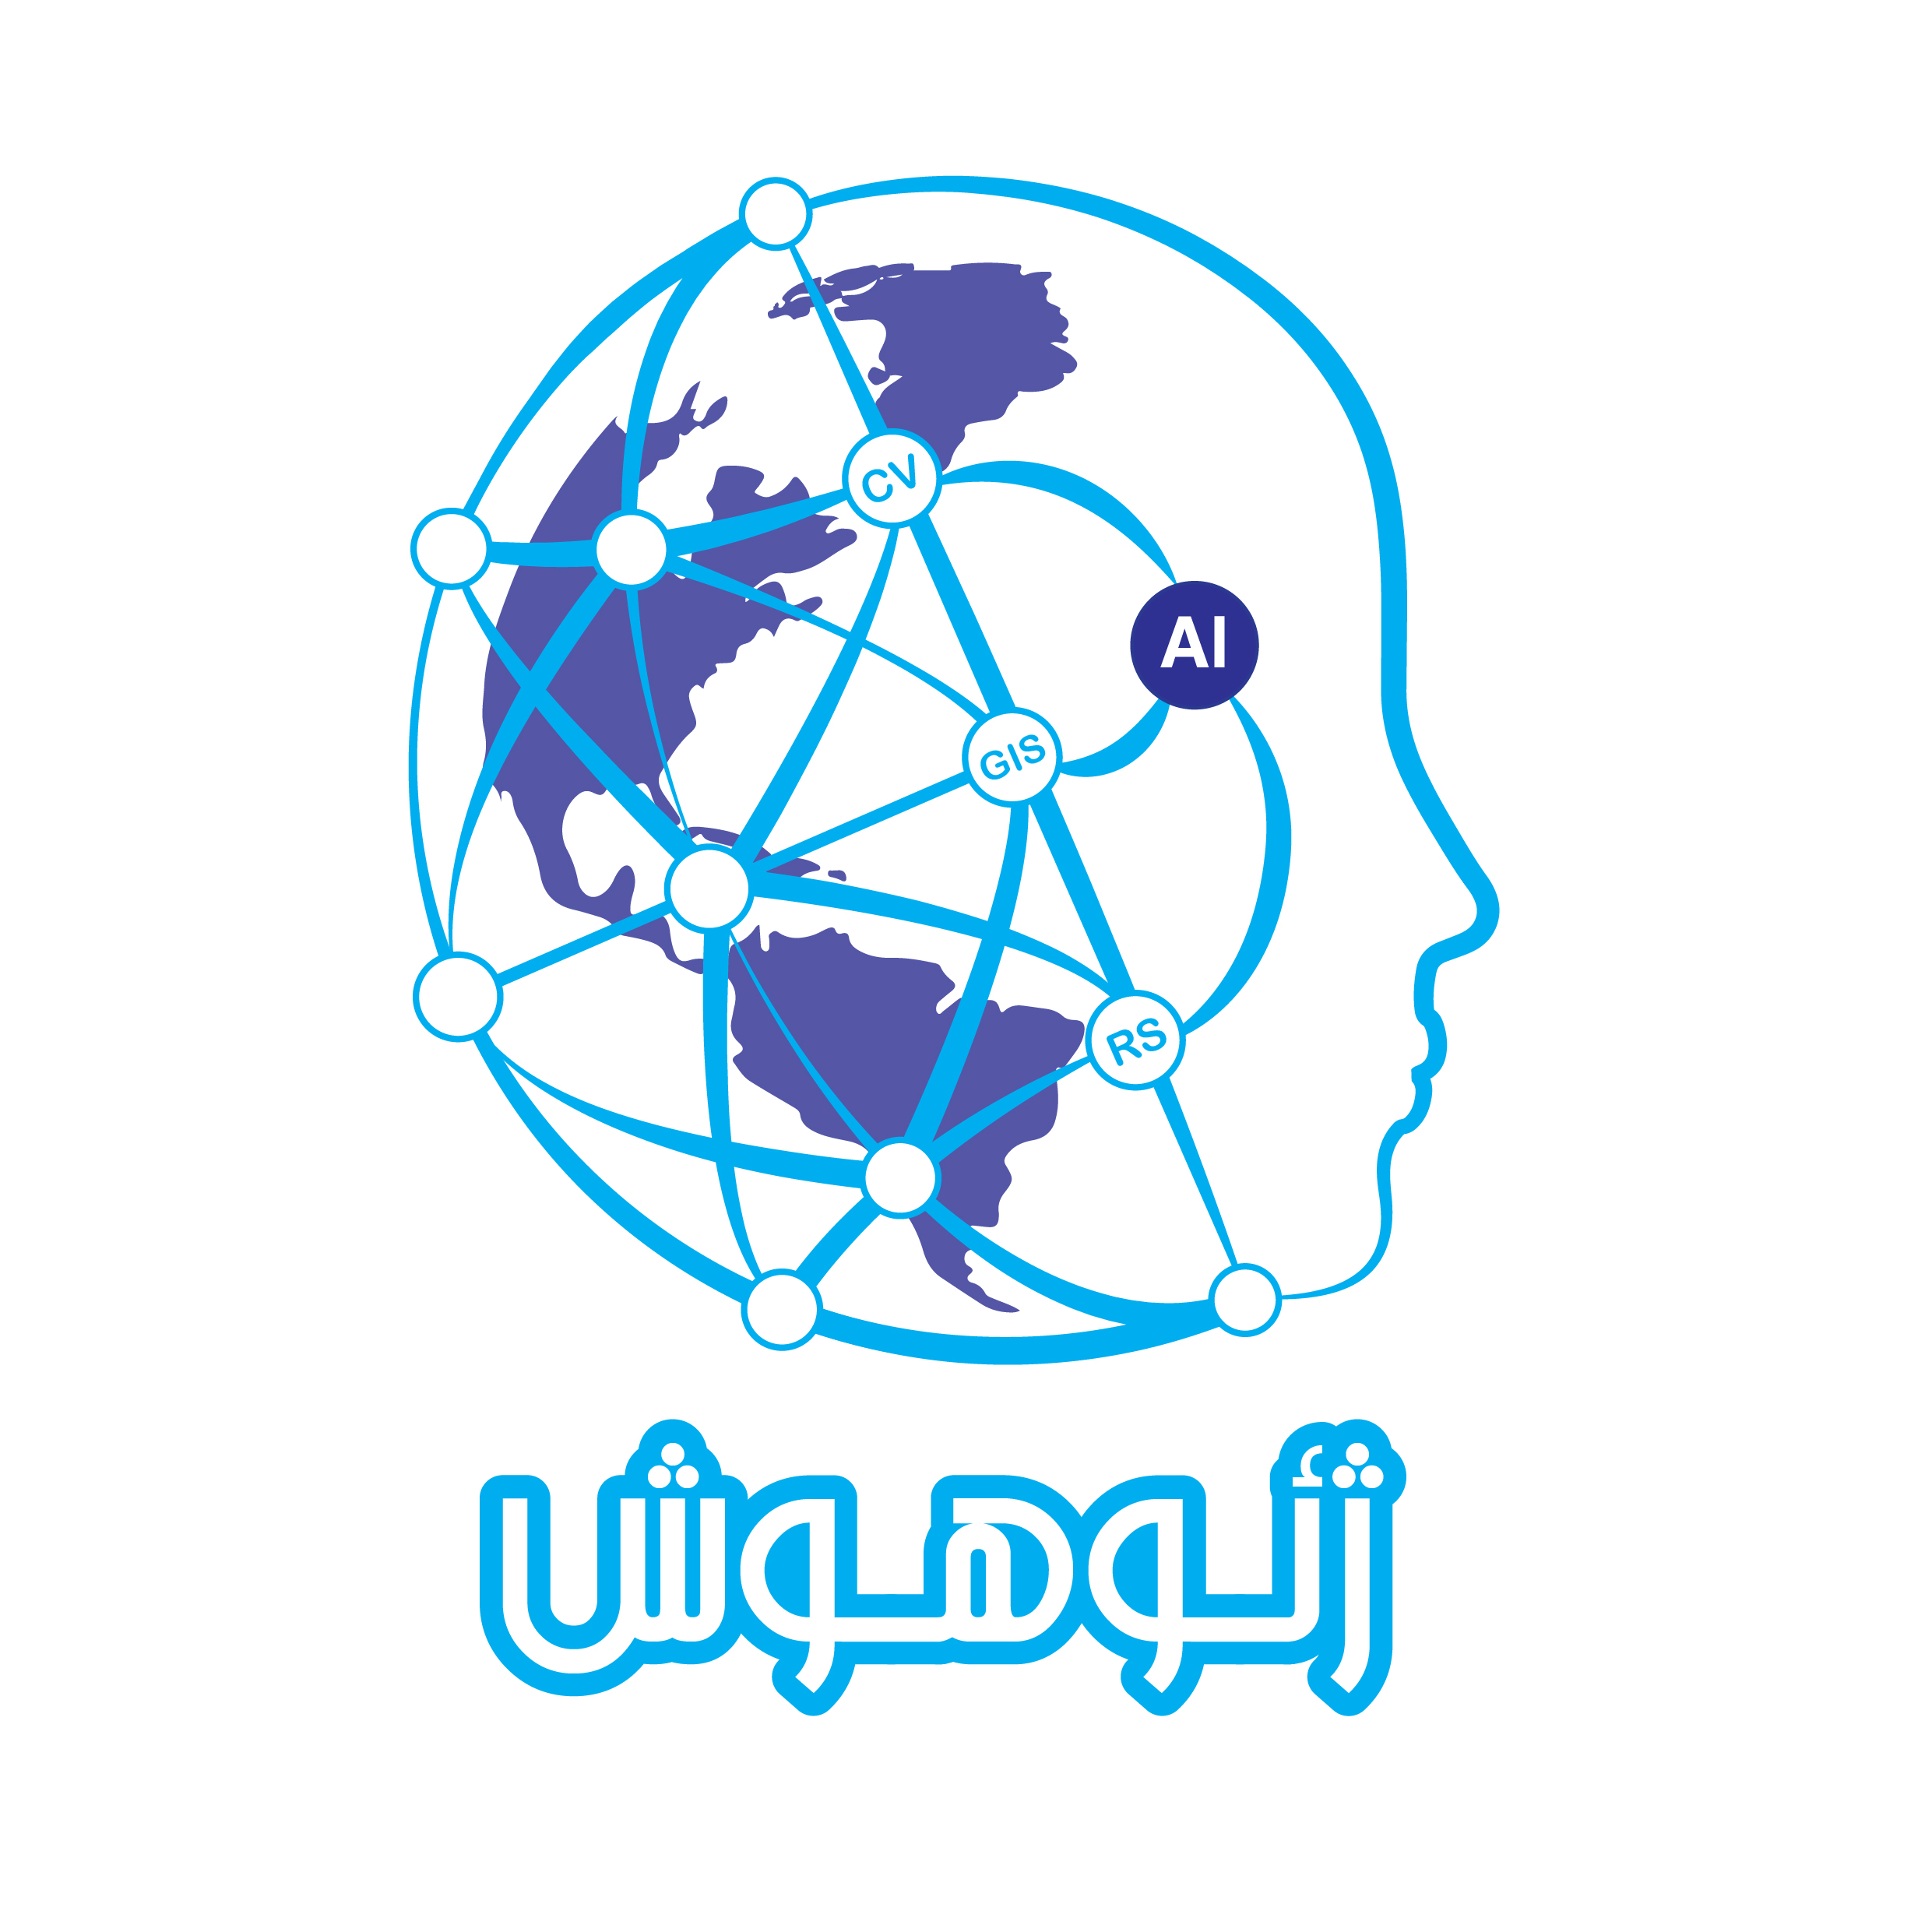

In [1]:
!pip install -y gdown


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [2]:
!gdown --id 15q0jOaxtbycyjQBpz4fWidsZkafWf5za

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15q0jOaxtbycyjQBpz4fWidsZkafWf5za
To: /content/Human_Horse.zip
100% 322M/322M [00:07<00:00, 41.3MB/s]


In [ ]:
!unzip /content/Human_Horse.zip

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_dir = '/content/horse-or-human/train'
validation_dir = '/content/horse-or-human/validation'

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

In [24]:
train_generator =  train_datagen.flow_from_directory(
    train_dir,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

test_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


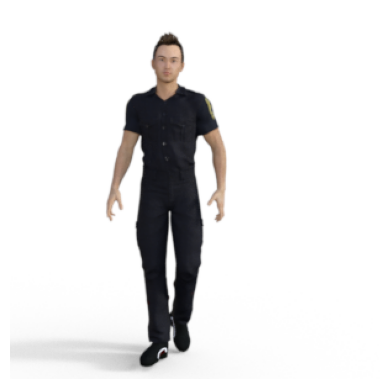

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/horse-or-human/validation/humans/valhuman01-00.png')[:,:,::-1]
img = np.expand_dims(img, axis = 0)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.applications import MobileNetV2
#BackBone
pre_trained_model = MobileNetV2(
    include_top = False,
    weights = None,
    input_shape = (160,160,3),
    pooling = max
)

In [9]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

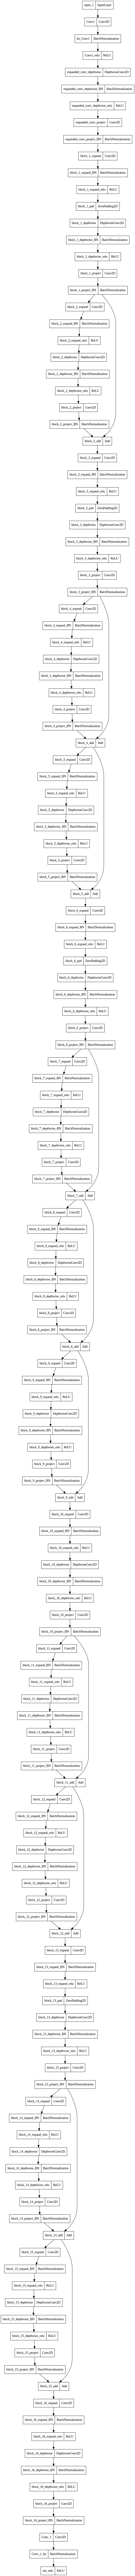

In [10]:
from keras.utils import plot_model
plot_model(pre_trained_model)

In [ ]:
print(len(pre_trained_model.layers))
for layer in pre_trained_model.layers:
  layer.trainable = False

154


In [11]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [12]:
len(pre_trained_model.layers)

154

In [14]:
last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output

In [15]:
last_output

<KerasTensor: shape=(None, 5, 5, 1280) dtype=float32 (created by layer 'out_relu')>

In [16]:
from keras.models import Model

In [17]:
x = Flatten()(last_output)
x = Dense(units = 32, activation='relu')(x)
x = Dropout(0.2)(x)
out_x = Dense(1, activation = 'sigmoid')(x)

In [18]:
model = Model(pre_trained_model.input , out_x)

In [20]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']        

In [22]:
#model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
check_point_path = '/content/models/best.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath = check_point_path,
    monitor='val_accuracy',
    save_weights_only=False,
    save_best_only=True,
    verbose = 1
)

In [25]:
print('Num Params : ',model.count_params())
history = model.fit(
    train_generator,
    epochs=5,
    verbose=1,
    validation_data=test_generator,
    callbacks = [model_checkpoint_callback]
)

Num Params :  3282049
Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 0.7210 - accuracy: 0.5492
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/models/best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 57s 839ms/step - loss: 0.7210 - accuracy: 0.5492 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.5628
Epoch 2: val_accuracy did not improve from 0.50000
17/17 [==============================] - 14s 838ms/step - loss: 0.6712 - accuracy: 0.5628 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.6125
Epoch 3: val_accuracy did not improve from 0.50000
17/17 [==============================] - 14s 795ms/step - loss: 0.6632 - accuracy: 0.6125 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.5969
Epoch 4: val_accuracy did not improve from 0.50000
17/17 [==============================] - 14s 792ms/step - loss: 0.6511 - accuracy: 0.5969 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
17/17 [=======================

In [26]:
model.evaluate(train_generator)

17/17 [==============================] - 12s 680ms/step - loss: 0.6933 - accuracy: 0.4869


[0.693261444568634, 0.4868549108505249]

In [27]:
model.evaluate(test_generator)

4/4 [==============================] - 1s 279ms/step - loss: 0.6932 - accuracy: 0.5000


[0.6931554079055786, 0.5]

In [28]:
pred = model.predict(test_generator)

4/4 [==============================] - 2s 276ms/step


Text(0.5, 1.0, 'Training and validation loss')

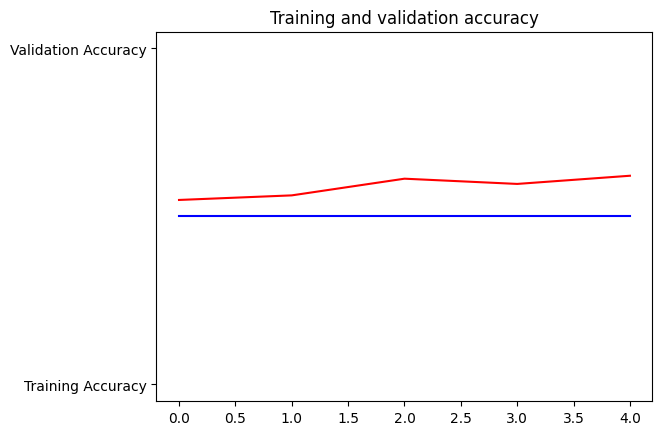

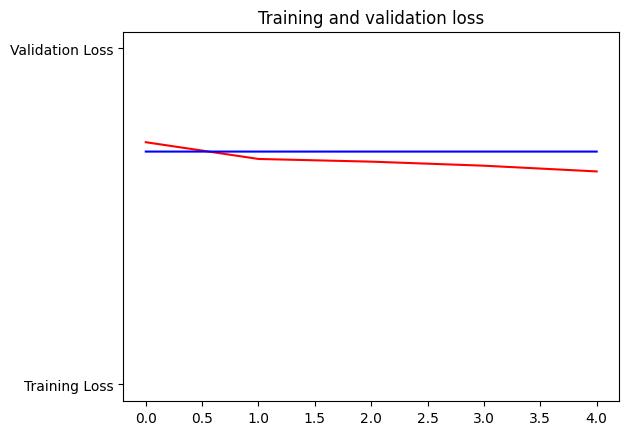

In [29]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [34]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(160,160))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.
    classes = model.predict(x, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")

Saving valhuman01-00.png to valhuman01-00.png
1/1 [==============================] - 0s 24ms/step
[0.49798268]
valhuman01-00.png is a horse


In [35]:
# from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow import keras

regularizer=keras.regularizers.l2(1e-3)
model1 = Sequential()

#1st block
model1.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (160,160,3), padding = 'same', kernel_initializer= 'he_uniform', kernel_regularizer=regularizer))
model1.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same' ,kernel_initializer= 'he_uniform', kernel_regularizer=regularizer))
model1.add(MaxPool2D())
model1.add(Dropout(0.2))

#2nd block
model1.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same' ,kernel_initializer= 'he_uniform', kernel_regularizer=regularizer))
model1.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same' ,kernel_initializer= 'he_uniform', kernel_regularizer=regularizer))
model1.add(MaxPool2D())
model1.add(Dropout(0.2))

#3rd block
model1.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same',kernel_initializer= 'he_uniform', kernel_regularizer=regularizer))
model1.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same',kernel_initializer= 'he_uniform', kernel_regularizer=regularizer))
model1.add(MaxPool2D())
model1.add(Dropout(0.2))

# Fully Connected
model1.add(Flatten())
model1.add(Dense(32, activation = 'relu', kernel_regularizer=regularizer))
model1.add(Dense(32, activation = 'relu', kernel_regularizer=regularizer))
model1.add(Dense(1, activation = 'sigmoid',kernel_initializer= 'he_uniform', kernel_regularizer=regularizer))

model1.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
batch_size = 64
epochs = 5

In [36]:
print('Num Params : ', model1.count_params())
model1.summary()

Num Params :  864721
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 80, 80, 16)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 80, 80, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 32)        9248      
                                   

In [37]:
# Model Check Points --> Save Best weights for Best resualts
from tensorflow.keras.callbacks import ModelCheckpoint
check_point_path_model1 = './models/Best_weight_model1.h5'
model_checkpoint_callback_model1 = ModelCheckpoint(filepath = check_point_path_model1,
     monitor = 'val_accuracy',
     save_weights_only = False,
     save_best_only = True,
     verbose = 1)

In [38]:
history1 = model1.fit(train_generator,batch_size = batch_size,epochs = epochs,verbose = 1,shuffle = True,validation_data = test_generator, callbacks = [model_checkpoint_callback])

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 1.3362 - accuracy: 0.4976
Epoch 1: val_accuracy did not improve from 0.50000
17/17 [==============================] - 18s 739ms/step - loss: 1.3362 - accuracy: 0.4976 - val_loss: 1.1477 - val_accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.5725
Epoch 2: val_accuracy did not improve from 0.50000
17/17 [==============================] - 14s 793ms/step - loss: 1.1257 - accuracy: 0.5725 - val_loss: 1.1186 - val_accuracy: 0.5000
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1.0203 - accuracy: 0.6582
Epoch 3: val_accuracy improved from 0.50000 to 0.56641, saving model to /content/models/best.h5
17/17 [==============================] - 13s 792ms/step - loss: 1.0203 - accuracy: 0.6582 - val_loss: 1.1629 - val_accuracy: 0.5664
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 0.9399 - accuracy: 0.7020
Epoch 4: val_accuracy did not impr

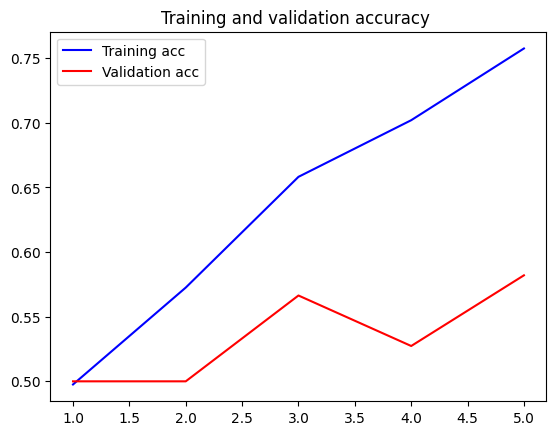

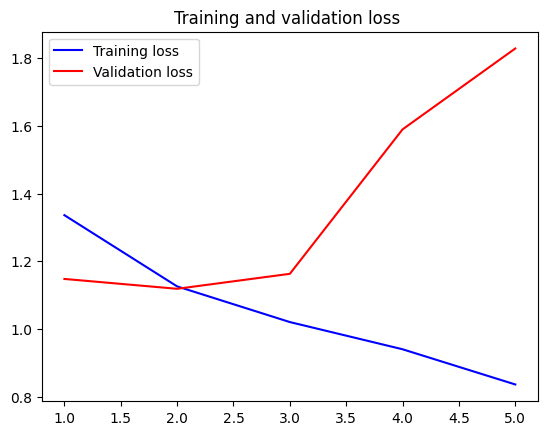

In [39]:
import matplotlib.pyplot as plt

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy ')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss ')
  plt.legend()

  plt.show()
plot_history(history1)

In [40]:
# evaluate the model1
scores = model1.evaluate(test_generator, verbose=1)
print("%s: %.2f%%" % (model1.metrics_names[:], scores[1]*100))

4/4 [==============================] - 1s 194ms/step - loss: 1.8288 - accuracy: 0.5820
['loss', 'accuracy']: 58.20%


In [43]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(160,160))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.
    classes = model1.predict(x, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")

Saving download.jpg to download.jpg
1/1 [==============================] - 0s 20ms/step
[0.07707036]
download.jpg is a horse
